# Developing Pastas models for different wells in Bangkok, Thailand.

- A well nest at a given location may have 1-4 wells
- Simulating groundwater levels
- Calibration period: typically from 1978-2020 (based on data
availability)
- Inputs: Basin-wide Pumping
- Outputs: Pastas models (.pas files), graphs

Author: Jenny Soonthornrangsan 2023, TU Delft

In [ ]:
###############################################################################
# Installing packages on colab
###############################################################################
!pip install pastas
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1" 
!pip install "basemap-data-hires == 1.3.0b1"
!pip install mycolorpy
!git clone https://github.com/jsoontho/BKKSubPastasModels.git
    
# Changing current directory to location of python script
%cd '/content/BKKSubPastasModels'

!git pull

__Note that if imports don't work. Check results from cell above and click `Restart Runtime.` Then rerun cells below (including import cell)__

In [6]:
###############################################################################
# import statements
###############################################################################

# Importing packages and libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
import os
import sys
import warnings

# Bangkok Subsidence Model Package
import bkk_sub_gw

# Importing script for pre-processing Thai GW data
import main_functions as mfs


In [2]:
# %%###########################################################################
# Plotting settings
###############################################################################

plt.rc('font', size=12)  # controls default text size
plt.rc('axes', titlesize=12)  # fontsize of the title
plt.rc('axes', labelsize=8)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)  # fontsize of the x tick labels
plt.rc('ytick', labelsize=8)  # fontsize of the y tick labels
plt.rc('legend', fontsize=8)  # fontsize of the legend

Currently, producing graphs for one well nest: LCBKK013 or BKK013 in the paper.

- Figure 7 in _Groundwater_ paper

Change `list_wellnest_flag = 1` to run for all well nests

In [10]:
# %%###########################################################################
# Pastas settings
###############################################################################

# If saving model, save_model = 1
save_model = 0

# If importing previous saved models, import_model = 1
import_model = 1

# If saving graphs, save_graph = 1
save_graph = 0

# Publication graphs
paper_graph = 1

# Additional figures
add_graph = 0

# Folder to save/import graph and model
modelpath = os.path.abspath("models")
figpath = os.path.abspath("figures")
pumppath = os.path.join(os.path.abspath("inputs"), 'BasinPumping.xlsx')
pumpsheet = 'EstTotalPump_54-60_Int50'

# If running with pumping
# If basin wide pumping set pump_basin_flag to 1
pump_basin_flag = 1

# Pumping response function
pump_rfunc = ps.Gamma()

# Solver
# Options: ps.LmfitSolve, ps.LeastSquares
# solver = ps.LeastSquares()

# Noise model
noise_TF = True

# Option to run all well nests, set flag to 1
list_wellnest_flag = 1

# If running only one well nest, set flag to 0, WellNest Name
Wellnest_name = ["LCBKK013"]

# Getting a list of all the wells
# Total path
tot_path = os.path.abspath("inputs")

# All well nest list
if list_wellnest_flag == 1:

    files = os.listdir(tot_path)
    files = [i.replace('.xlsx', '') for i in files
             if i.startswith('LC') and "_" not in i]

else:
    files = Wellnest_name

INFO: Time Series Head: 4 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\Downloads\Publications\1stPaper\CodeFig\models\LCBKK013_PD32_GW_1989_2020_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Head: 7 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\Downloads\Publications\1stPaper\CodeFig\models\LCBKK013_NL45_GW_1989_2020_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Head: 5 nan-value(s) was/were found and filled with: drop.
INFO: Time Series Head: User-defined option for fill_before 'None' is not supported.
INFO: Pastas Model from file C:\Users\jtsoonthornran\Downloads\Publications\1stPaper\CodeFig\models\LCBKK013_NB38_GW_1989_2020_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your 

Wellnest: LCBKK013


INFO: Time Series Pump was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Pump was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.


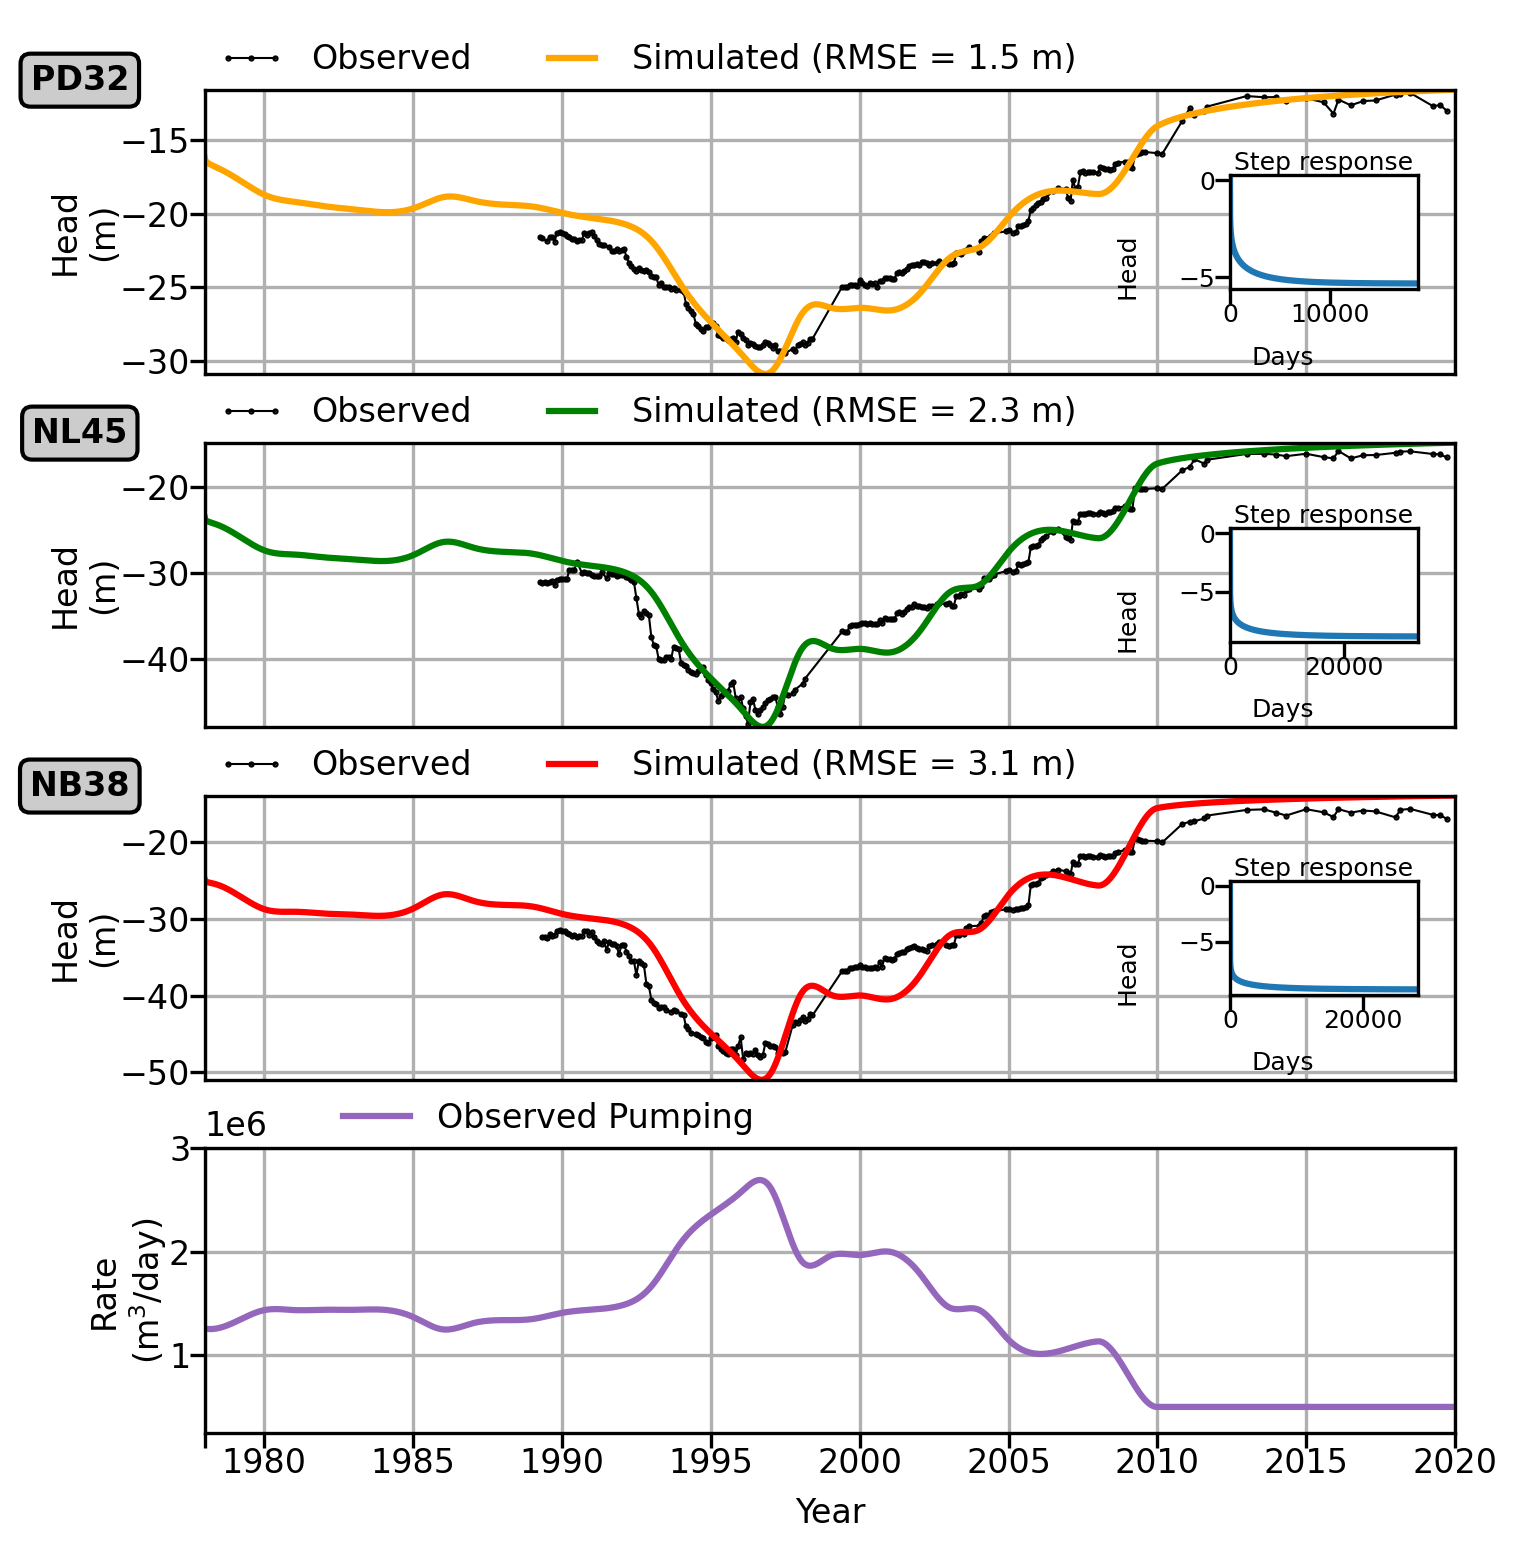

In [9]:
###############################################################################
# Creating/Importing and Plotting Pastas Model
###############################################################################

# For each well nest
for Wellnest_name in files:

    # Saving results for each well nest
    models = []
    time_mins = []
    time_maxs = []
    well_names = []

    # Reading in groundwater data
    full_path = os.path.join(tot_path, Wellnest_name + '.xlsx')
    data = pd.read_excel(full_path, skiprows=3)

    # For all wells in well nest
    for wells in data.columns[-(len(data.columns)-2):]:

        # Name of well as a string
        well_name = wells

        #######################################################################
        # Creating Pastas Model
        #######################################################################
        # If not importing, then creating new models
        if import_model == 0:

            # Preprocessing head data
            # Inputing in raw data for well nest and well name
            # Output: head data relative to 0 for the entire well nest
            #         head data relative to 0 m for specific well
            all_head_data, gw_well_head = mfs.GW_Data_Process(data,
                                                              well_name)
            print('\nGW obs imported for ' + Wellnest_name + ' and ' +
                  well_name + '\n')

            # CORRECTING GW HEAD DATA TO LAND SURFACE (COASTAL DEM 2.1)
            # Reading in land surface elevation for each well nest
            landsurf_path = os.path.join(tot_path,
                                         'LandSurfElev_GWWellLocs.xlsx')
            landsurf_data = pd.read_excel(landsurf_path,
                                          sheet_name='2.1',
                                          usecols="C:F",
                                          index_col=0)

            # Correcting head relative to 0 m to be head relative to a
            # global datum.
            # Corrected by adding land surface elevation values to
            # head values relative to 0 m
            gw_well_head.Head += (landsurf_data.RASTERVALU.loc[Wellnest_name])

            # Saving years and annual average heads
            gw_well_head["year"] = gw_well_head.index.year  # Saving year
            gw_year = gw_well_head.groupby(gw_well_head["year"]).mean()
            gw_year["Date"] = pd.to_datetime(gw_year.index, format='%Y')
            gw_year.index = gw_year.Date  # Setting index as date
            gw_year["year"] = gw_year.index.year  # Saving year

            # Setting time min and time max to first and last obs year
            time_min = str(gw_year[gw_year.Head.notna()].year[0])
            time_max = str(gw_year[gw_year.Head.notna()].year[-1])

            # Gets rid of data not within min and max time
            gw_year = gw_year[(gw_year['year'] >= int(time_min)) &
                              (gw_year['year'] <= int(time_max))]

            # If GW well does not have data within time period, skips this well
            if gw_year.Head.isnull().all():
                print("\nSkipping ", well_name,
                      "because no head values in time period\n\n\n")
                continue

            # Initializing model
            model = ps.Model(gw_well_head.Head)
            print("\nModel initialized for GW\n")

            # Initial steady state heads estimate for d constant
            # Steady state heads already realtive to same global datum
            # as land surface elevation
            SS_path = os.path.join(tot_path,
                                   'SS_Head_GWWellLocs.xlsx')
            SS_data = pd.read_excel(SS_path,
                                    sheet_name='SS_Py',
                                    index_col=0)

            # Getting steady state heads according to aquifer
            if "BK" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "BK"]

            elif "PD" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "PD"]

            elif "NL" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "NL"]

            elif "NB" in well_name:

                initial_d = SS_data.loc[Wellnest_name, "NB"]

            # Setting d parameter to SS heads and to vary +/- initial
            # estimates
            model.set_parameter(name="constant_d",
                                initial=initial_d,
                                pmin=initial_d-10,
                                pmax=initial_d+10,
                                vary=True)

            ###################################################################
            # Adding pumping data
            ###################################################################
            if pump_basin_flag == 1:

                # Daily interpolated and estimated pumping rates for the basin
                # from simulated (Chula report)
                EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet,
                                           index_col=0, parse_dates=['Date'])

                # Creating stress model
                EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc,
                                             name="well", settings="well",
                                             up=False)
                # Adding stress model
                model.add_stressmodel(EstTotPump_)
                print('\nPumping obs added basin-wide\n')

            ###################################################################
            # Solving/Saving Pastas Model
            ###################################################################
            # Try running model
            try:
                print("Running....")

                # If noise model True
                if noise_TF == True:

                    # First run is not with noise model
                    # Gets first parameter estimates
                    # Warm up is 30 years
                    model.solve(tmin=time_min, tmax=time_max,
                                report=False, noise=False,
                                solver=ps.LeastSquares(), warmup=365*30)

                    # Second run with noise model using initial
                    # parameters as the calibrated parameters from
                    # first run
                    model.solve(tmin=time_min, tmax=time_max,
                                initial=False, report=False,
                                noise=noise_TF, solver=ps.LeastSquares(),
                                warmup=365*30)

                # Noise model False
                else:

                    # First run is not with noise model
                    # Gets first parameter estimates
                    # Warm up is 30 years
                    model.solve(tmin=time_min, tmax=time_max,
                                report=False, noise=False,
                                solver=ps.LeastSquares(), warmup=365*30)

                    # Second run with noise model using initial
                    # parameters as the calibrated parameters from
                    # first run
                    model.solve(tmin=time_min, tmax=time_max,
                                initial=False, report=False,
                                noise=noise_TF, solver=ps.LeastSquares(),
                                warmup=365*30)

            # If time series out of bounds
            except ValueError:
                print('Time series out of bounds.\nCannot run model')
                sys.exit()

            # If saving model
            if save_model == 1:
                model.to_file(modelpath + "/" + Wellnest_name + '_' +
                              well_name + '_GW_' + time_min + '_' + time_max +
                              '_model.pas')

        #######################################################################
        # Importing Pastas Model
        #######################################################################
        # If importing Pastas model
        else:

            # Model files
            modelfiles = os.listdir(modelpath)

            # If file exists:
            try:

                # Load existing model
                wellmodel = [s for s in modelfiles
                             if np.logical_and(Wellnest_name in s,
                                               well_name in s)][0]
                model = ps.io.load(modelpath + "/" + wellmodel)

                # Gets time min and max from file name
                time_min = wellmodel[wellmodel.find("_1")+1:wellmodel.find("_1")+5]
                time_max = wellmodel[wellmodel.find("_2")+1:wellmodel.find("_2")+5]

                # Saving optimal parameters before deleting stress
                optiparam = model.parameters["optimal"]
                stdparam = model.parameters["stderr"]

                # Deleting stress
                model.del_stressmodel("well")

                # Adding new pumping stress time series
                # If the same pumping stress time series, then
                # optimal parameters are the same
                EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet,
                                           index_col=0, parse_dates=['Date'])
                EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc,
                                             name="well", settings="well",
                                             up=False)

                # Adding new stress model
                model.add_stressmodel(EstTotPump_)

                # Setting the same optimal parameters
                model.parameters["optimal"] = optiparam
                model.parameters["stderr"] = stdparam

            # If does not exist
            except FileNotFoundError:
                print("No model for " + Wellnest_name + "_" + well_name)
                continue

        # Saving Pastas model, Well_name
        models.append(model)
        well_names.append(well_name)

        ###########################################################################
        # Pastas Plotting and Graphing
        ###########################################################################

        # set plotting time min and time max
        if "BK" in well_name:
            ptime_min = '1986'
        else:
            ptime_min = '1978'
        ptime_max = "2020"

        # Saving time_mins and time_maxs
        time_mins.append(ptime_min)
        time_maxs.append(ptime_max)

        # If plotting additional graphs
        if add_graph == 1:

            # Plotting for calibrated time period
            ax = model.plot(tmin=ptime_min, tmax=ptime_max,
                            figsize=(10, 6))

            # Setting yaxis limits
            # Different for wells in different aquifers
            if "BK" in well_name:
                plt.ylim(-25, -5)
            elif "PD" in well_name:
                # Well nests with big variation in head
                if Wellnest_name == "LCBKK036" or \
                        Wellnest_name == "LCSPK007":
                    plt.ylim(-55, -10)
                # Rest of wells
                else:
                    plt.ylim(-30, -5)
            elif "NL" in well_name:
                plt.ylim(-70, -10)
            elif "NB" in well_name:
                plt.ylim(-60, -5)

            # If saving graphs
            if save_graph == 1:

                # First figure from plot
                # Fig name
                fig_name1 = Wellnest_name + '_' + well_name + '_GW_' + \
                    time_min + '_' + time_max + '_1.png'
                # Fig path
                full_figpath = os.path.join(figpath, fig_name1)
                # Saving fig
                plt.savefig(full_figpath, dpi=150, bbox_inches='tight',
                            format='png')

                # Second figure
                model.plots.results(tmin=ptime_min, tmax=ptime_max,
                                    figsize=(10, 6))
                # Fig name
                fig_name2 = Wellnest_name + '_' + well_name + '_GW_' + \
                    time_min + '_' + time_max + '_2.png'
                # Fig path
                full_figpath = os.path.join(figpath, fig_name2)
                # Saving fig
                plt.savefig(full_figpath, dpi=150, bbox_inches='tight',
                            format='png')

            # If not saving graphs
            else:

                model.plots.results(tmin=time_min, tmax=time_max,
                                    figsize=(10, 6))

    # If replicating publication figures
    if paper_graph == 1:

        print("Wellnest: " + Wellnest_name)
        bkk_sub_gw.bkk_plotting.Pastas_results(models, Wellnest_name,
                                               well_names, time_mins,
                                               time_maxs, figpath, save_graph)